In [111]:
#import libraries needed

#libraries to read data and work with it
import pandas as pd
import numpy as np

#library to plot graph
import matplotlib.pyplot as plt

#libraries for feature vectors using Bag Of Words(BOW), TFIDF   
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

#library for metrics calculation
from sklearn.metrics import f1_score, precision_score, recall_score

#library for output class encoding
from keras.utils import to_categorical

#libraries for CNN model
from keras.models import Sequential
from keras.layers import Conv1D, Activation, MaxPooling1D, AveragePooling1D, Dropout, Flatten,  Dense
from keras import optimizers

#libraries for pre-processing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [112]:
#read dataset 
data = pd.read_csv('https://raw.githubusercontent.com/cacoderquan/Sentiment-Analysis-on-the-Rotten-Tomatoes-movie-review-dataset/master/train.tsv', sep='\t') 
data = data.dropna()
#print shape of the dataset
data.shape

(156060, 4)

In [113]:
#display first 5 records in the dataset
data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


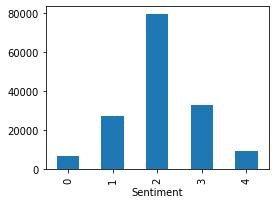

In [114]:
#Display Phrase count based on sentiment
fig = plt.figure(figsize=(4,3))
data.groupby('Sentiment').Phrase.count().plot.bar(ylim=0)
plt.show()

In [0]:
#tokenization
documents = []
for i in range(data.shape[0]):
  tmpWords = word_tokenize(data['Phrase'][i])
  documents.append((tmpWords, data['Sentiment'][i]))

In [116]:
#data pre-processing
porter = PorterStemmer()
lancaster=LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stopwords_en = stopwords.words("english")
punctuations="?:!.,;'\"-()"

#parameters to adjust to see the impact on outcome
remove_stopwords = True
useStemming = False
useLemma = True
removePuncs = True

for l in range(len(documents)):
  label = documents[l][1]
  tmpReview = []
  for w in documents[l][0]:
    newWord = w
    if remove_stopwords and (w in stopwords_en):
      continue
    if removePuncs and (w in punctuations):
      continue
    if useStemming:
      #newWord = porter.stem(newWord)
      newWord = lancaster.stem(newWord)
    if useLemma:
      newWord = wordnet_lemmatizer.lemmatize(newWord)
    tmpReview.append(newWord)
  documents[l] = (' '.join(tmpReview), label)
print(documents[2])

('A series', 2)


In [0]:
all_data = pd.DataFrame(documents, columns=['Phrase', 'Sentiment'])

#Data split int train and test data
X_train, X_test, Y_train, Y_test = train_test_split(all_data ['Phrase'], all_data ['Sentiment'], test_size=0.3, random_state=2003)

In [118]:
#Bag Of Words(BOW) vectorizer 
BOW_vectorizer = CountVectorizer(max_features = 2000)
#BOW_vectorizer = TfidfVectorizer(max_features = 2000)
BOW_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=2000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
#Feature vector transformation
X_train_BOW = BOW_vectorizer.transform(X_train)
X_test_BOW = BOW_vectorizer.transform(X_test)

In [0]:
#convert to array
X_train_BOW = X_train_BOW.toarray()
X_test_BOW = X_test_BOW.toarray()

#for metrics calculation
Y_test_metrics = Y_test

#one hot encoding
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [121]:
#reshape 2D array to 3D array so that it can be fed into the model
X_train_BOW=X_train_BOW.reshape(X_train_BOW.shape[0],X_train_BOW.shape[1],1)
print(X_train_BOW.shape)

X_test_BOW=X_test_BOW.reshape(X_test_BOW.shape[0],X_test_BOW.shape[1],1) 
print(X_test_BOW.shape)

(109242, 2000, 1)
(46818, 2000, 1)


In [0]:
#define cnn model
def cnn_model(input, output_class):
  #create model
  model = Sequential()
  model.add(Conv1D(filters = 128, kernel_size=1, activation='relu', input_shape=(input.shape[1],1)))
  model.add(MaxPooling1D(pool_size =2))
  model.add(Conv1D(filters = 256, kernel_size=1, activation='relu'))
  model.add(MaxPooling1D(pool_size =2))
  model.add(Flatten())
  model.add(Dropout(.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(output_class, activation='softmax'))
  return model

In [0]:
#set learning rate, batch size, number of epochs and number of output labels
lr = 1e-5
batch_size = 128
epochs = 10
output_class = 5

model = cnn_model(X_train_BOW, output_class)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [124]:
#Train the Model and save it
model.fit(X_train_BOW, Y_train, epochs = epochs, batch_size = batch_size)

model.save("1094107_1dconv_reg.h5")

Epoch 1/10
109242/109242 [==============================] - 84s 769us/step - loss: 1.1412 - acc: 0.5492
Epoch 2/10
109242/109242 [==============================] - 83s 756us/step - loss: 1.0774 - acc: 0.5773
Epoch 3/10
109242/109242 [==============================] - 83s 756us/step - loss: 1.0168 - acc: 0.6036
Epoch 4/10
109242/109242 [==============================] - 82s 755us/step - loss: 0.9645 - acc: 0.6259
Epoch 5/10
109242/109242 [==============================] - 83s 756us/step - loss: 0.9279 - acc: 0.6401
Epoch 6/10
109242/109242 [==============================] - 83s 756us/step - loss: 0.8999 - acc: 0.6516
Epoch 7/10
109242/109242 [==============================] - 83s 757us/step - loss: 0.8796 - acc: 0.6602
Epoch 8/10
109242/109242 [==============================] - 83s 756us/step - loss: 0.8611 - acc: 0.6676
Epoch 9/10
109242/109242 [==============================] - 83s 757us/step - loss: 0.8477 - acc: 0.6733
Epoch 10/10
109242/109242 [==============================] - 83s

In [125]:
#load the trained model
from keras.models import load_model
model = load_model('1094107_1dconv_reg.h5')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 2000, 128)         256       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 1000, 128)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1000, 256)         33024     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 500, 256)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 128000)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 128000)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)             

In [126]:
#Calculate loss and accuracy
loss, accuracy = model.evaluate(X_test_BOW, Y_test)
print("Model Performace:")
print("The model's Accuracy is: " + str(accuracy))
print("The model's Loss is: " + str(loss))

46818/46818 [==============================] - 14s 299us/step
Model Performace:
The model's Accuracy is: 0.6023965141612201
The model's Loss is: 1.080283404252139


In [127]:
y_pred = model.predict(X_test_BOW, batch_size=128, verbose=1)
Y_pred = np.argmax(y_pred, axis=1)

#expected output labels for metrics calculation 
Y_test = np.array(Y_test_metrics)

#f1, precision, and recall score
precision = precision_score(Y_test, Y_pred , average="macro")
recall = recall_score(Y_test, Y_pred , average="macro")
f1_score_val = f1_score(Y_test, Y_pred , average="macro")

print("Model Performace:")
print("The model's Accuracy is: " + str(accuracy*100))
print("The model's Loss is: " + str(loss))
print("The model's Precision is: " + str(precision))
print("The model's Recall is: " + str(recall))
print("The model's f1-score is: " + str(f1_score_val))


46818/46818 [==============================] - 12s 254us/step
Model Performace:
The model's Accuracy is: 60.23965141612201
The model's Loss is: 1.080283404252139
The model's Precision is: 0.5178073603377571
The model's Recall is: 0.4283853733699693
The model's f1-score is: 0.4571801073332333
